# GF - CIFAR (Naive + Splines)

In [1]:
# @title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os

    os.system("pip install objax chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
# jax packages
import jax
import jax.numpy as jnp
from jax.config import config

# import chex
config.update("jax_enable_x64", False)

import chex
import numpy as np
from functools import partial

# library functions
from rbig_jax.data import get_classic
from rbig_jax.transforms.parametric.mixture.logistic import InitMixtureLogisticCDF
from rbig_jax.transforms.parametric.mixture.gaussian import InitMixtureGaussianCDF
from rbig_jax.transforms.logit import InitLogitTransform
from rbig_jax.transforms.inversecdf import InitInverseGaussCDF
from rbig_jax.transforms.parametric.householder import InitHouseHolder
from distrax._src.bijectors.sigmoid import Sigmoid
from distrax._src.bijectors.inverse import Inverse

# Plot utilities
from rbig_jax.custom_types import ImageShape
from rbig_jax.plots import plot_image_grid


KEY = jax.random.PRNGKey(123)

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import corner
from IPython.display import HTML

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

import warnings

warnings.filterwarnings("ignore")

%load_ext lab_black
%matplotlib inline
%load_ext autoreload
%autoreload 2

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [3]:
import wandb

wandb_logger = wandb.init(project="gf_cifar10_naive", entity="ipl_uv")

wandb_logger.config.seed = 123

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ml4floods (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.28 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


## Demo Data

In this demonstration, we will be using the "mnist" dataset.

In [4]:
import tensorflow_datasets as tfds
from typing import Iterator, Mapping
import numpy as np

Batch = Mapping[str, np.ndarray]


def load_dataset(split: tfds.Split, batch_size: int) -> Iterator[Batch]:
    ds = tfds.load("cifar10", split=split, shuffle_files=True)
    ds = ds.shuffle(buffer_size=10 * batch_size)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=10)
    ds = ds.repeat()
    return iter(tfds.as_numpy(ds))

(<Figure size 720x720 with 50 Axes>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x7f65878f7190>)

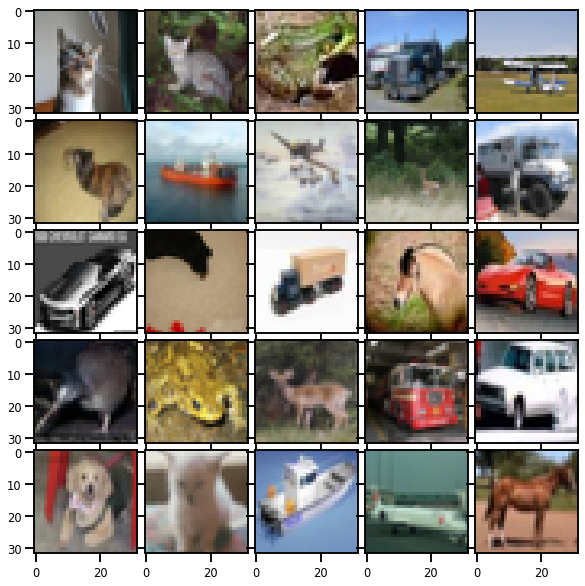

In [5]:
# train/valid dataset loaders
wandb_logger.config.batch_size = 64
n_init_samples = 30_000
train_ds = load_dataset(tfds.Split.TRAIN, 64)
init_ds = load_dataset(tfds.Split.TRAIN, n_init_samples)
valid_ds = load_dataset(tfds.Split.TEST, 64)


# demo batch
demo_batch = next(train_ds)

# plot batch of images
plot_image_grid(demo_batch["image"])

### Preprocessing Steps

1. Dequantize the variables

Basically add some uniform noise to help with training.

2. Normalize the pixels

We constrain the pixels to be from $[0, 256)$ to $[0, 1)$.

In [6]:
from typing import Optional
from chex import Array
from einops import rearrange

PRNGKey = Array


def prepare_data(batch: Batch, prng_key: Optional[PRNGKey] = None) -> Array:

    # select image from tfds
    data = batch["image"].astype(np.float32)

    # dequantize pixels (training only)
    if prng_key is not None:
        # Dequantize pixel values {0, 1, ..., 255} with uniform noise [0, 1).
        data += jax.random.uniform(prng_key, data.shape)

    # flatten image data
    data = rearrange(data, "B H W C -> B (H W C)")

    return data / 256.0  # Normalize pixel values from [0, 256) to [0, 1).

#### Demo

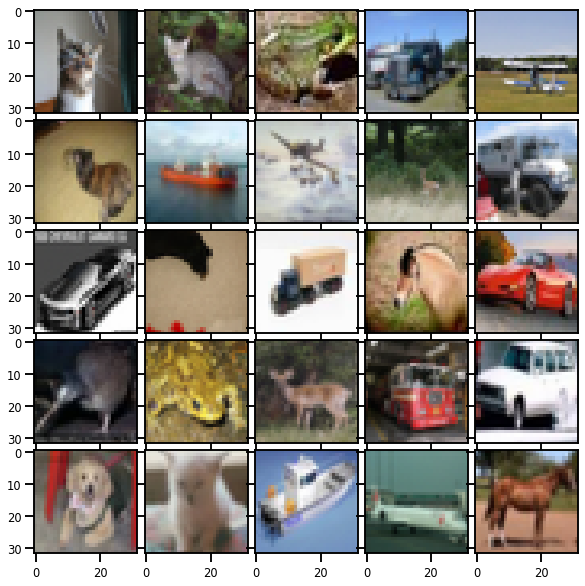

In [7]:
# create key
rng, prng_key = jax.random.split(KEY, num=2)

# prep the data
demo_data_prepped = prepare_data(demo_batch, prng_key=prng_key)

# plot image grid
image_shape = ImageShape(C=3, H=32, W=32)
fig, ax = plot_image_grid(demo_data_prepped, image_shape)

wandb.log({"demo_images_prepped": wandb.Image(plt)})

## Model

In [8]:
# initialization data
init_ds = load_dataset(tfds.Split.TRAIN, n_init_samples)
init_ds = next(init_ds)
init_data_prepped = prepare_data(init_ds, prng_key=prng_key)
X_init = np.array(init_data_prepped)

# marginal uniformization
n_bins = 16
range_min = 0.0
range_max = 1.0
boundary_slopes = "unconstrained"
identity_init = False

# rotation transformation
n_reflections = 50
init_rotation = "random"

# nn params
n_blocks = 6
plot_layers = False
plot_blocks = False

In [9]:
from rbig_jax.models.gaussflow import init_gf_spline_model

# init model
gf_model = init_gf_spline_model(
    shape=X_init.shape[1:],
    X=X_init,
    n_blocks=n_blocks,
    n_bins=n_bins,
    range_min=range_min,
    range_max=range_max,
    boundary_slopes=boundary_slopes,
    identity_init=identity_init,
    init_rotation=init_rotation,
    n_reflections=n_reflections,
    plot_layers=plot_layers,
    plot_blocks=plot_blocks,
)

Initializing - Block: 6 | Layer 11: 100%|██████████| 6/6 [00:59<00:00,  9.90s/it]


#### Demo

In [10]:
import warnings

warnings.filterwarnings("ignore")

CPU times: user 7.88 s, sys: 329 ms, total: 8.21 s
Wall time: 5.24 s


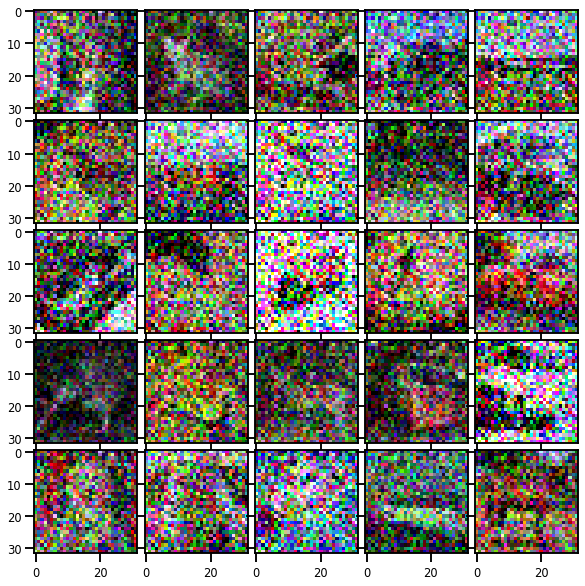

In [11]:
%%time

# forward propagation for data
X_demo_g = gf_model.forward(demo_data_prepped)

# plot demo images
# plot image grid
fig, ax = plot_image_grid(X_demo_g, image_shape)

wandb.log({"initial_latent_images": wandb.Image(plt)})

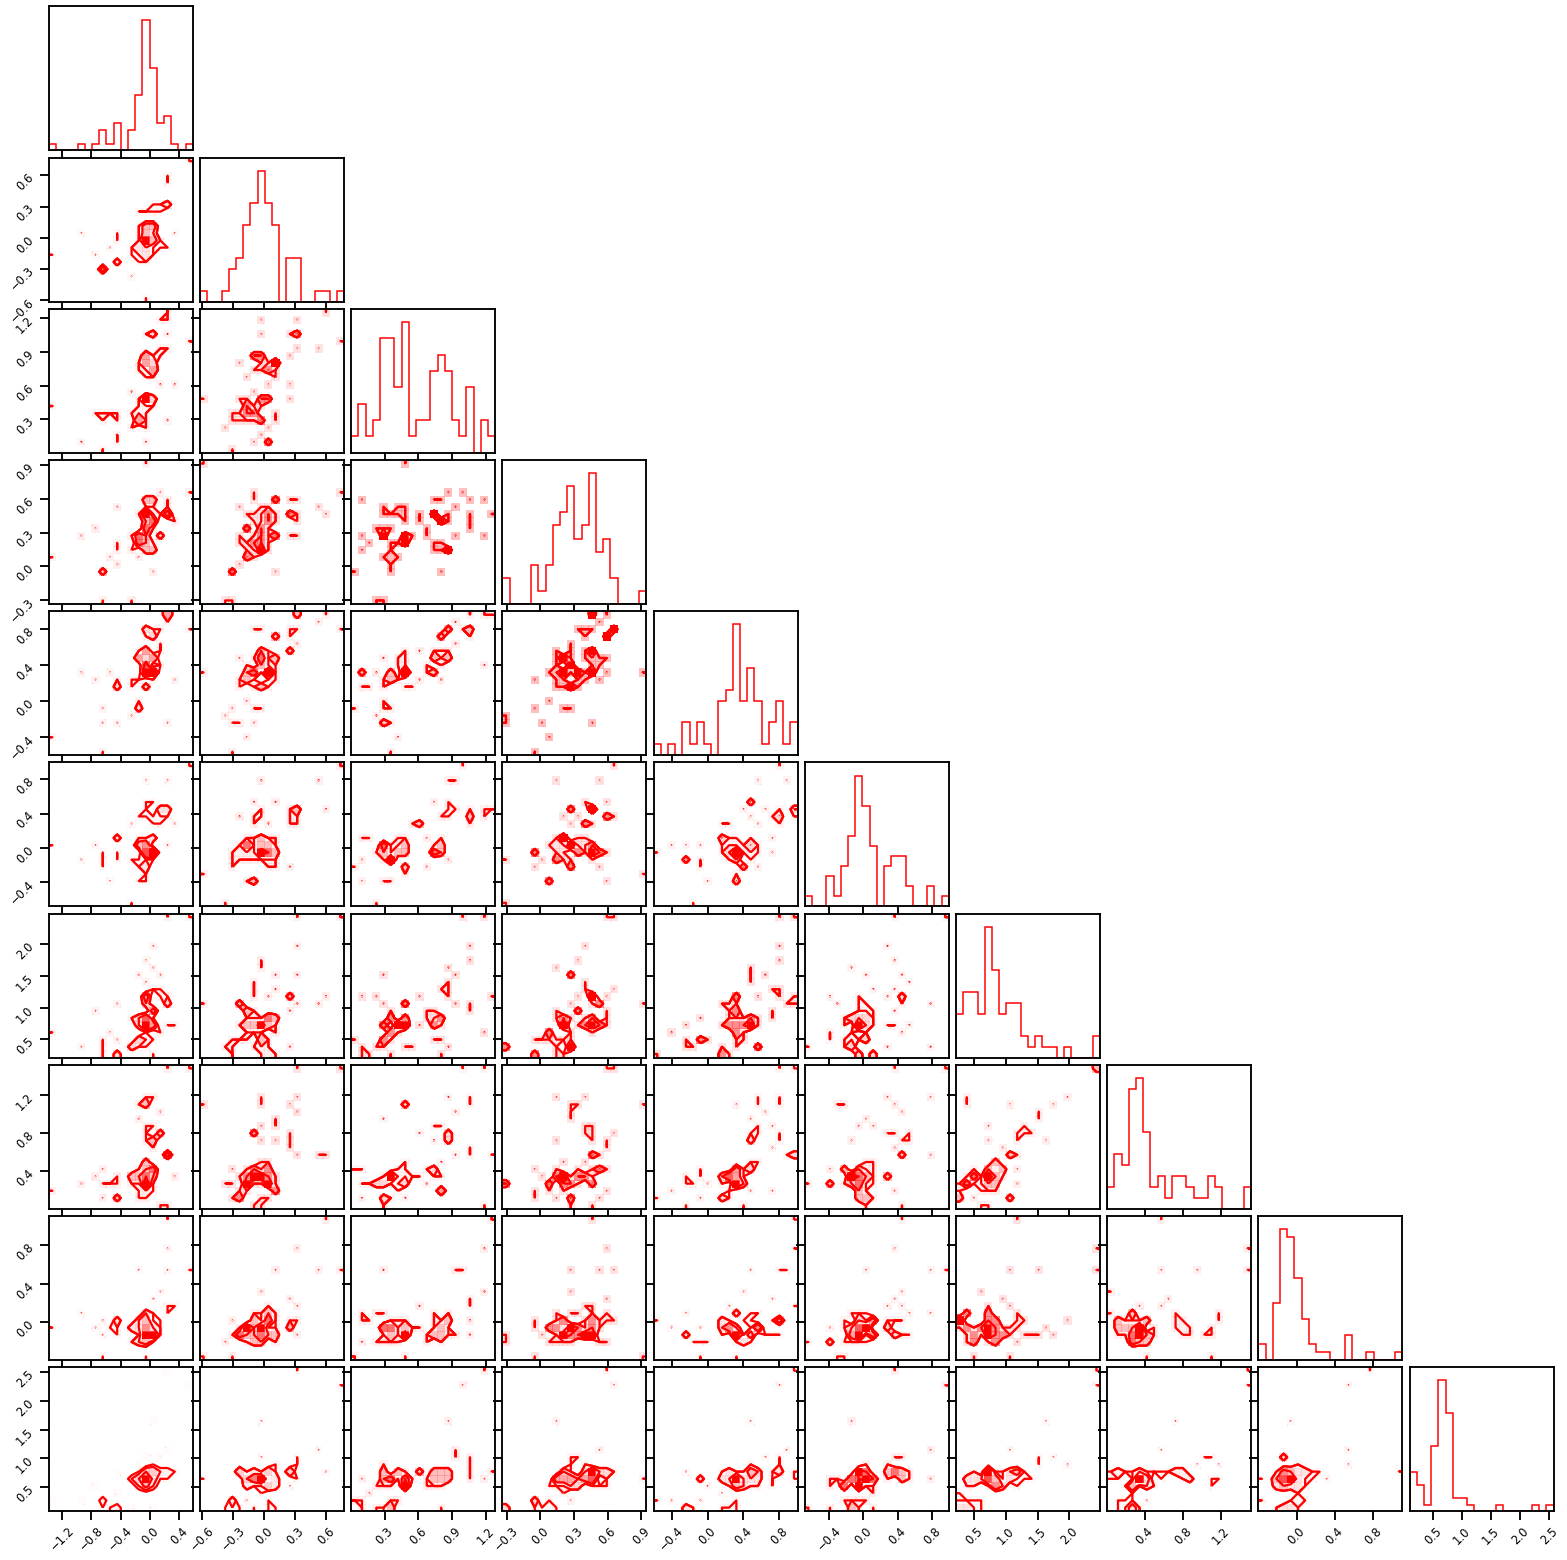

In [12]:
fig = corner.corner(np.array(X_demo_g[:, :10]), color="red")
wandb.log({"initial_latent_histogram": wandb.Image(plt)})

CPU times: user 4.42 s, sys: 224 ms, total: 4.65 s
Wall time: 3.93 s


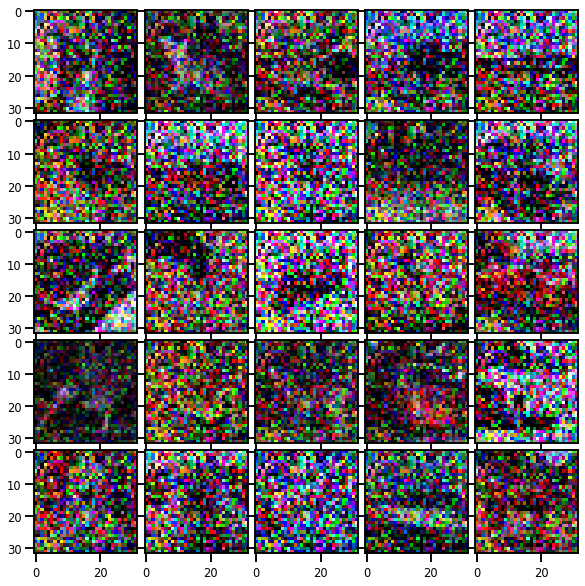

In [20]:
%%time

# forward propagation for data
X_demo_approx = gf_model.inverse(X_demo_g)

# plot demo images
fig, ax = plot_image_grid(X_demo_approx, image_shape)

wandb.log({"initial_inverse_images": wandb.Image(plt)})

### Loss Function

We're going to minimize the log probability

In [14]:
from chex import dataclass


def loss_fn(model: dataclass, prng_key: PRNGKey, batch: Batch) -> Array:

    # prepare data
    data = prepare_data(batch, prng_key)

    # negative log likelihood loss
    nll_loss = model.score(data)

    return nll_loss


def eval_fn(model: dataclass, batch: Batch) -> Array:

    # prepare data
    data = prepare_data(batch)

    # negative log likelihood loss
    nll_loss = model.score(data)

    return nll_loss


def forward_fn(model: dataclass, batch: Batch) -> Array:

    # prepare data
    data = prepare_data(batch)

    # negative log likelihood loss
    X_g = model.forward(data)

    return X_g

#### Demo

In [15]:
nll_loss = loss_fn(gf_model, prng_key, demo_batch)
print(f"Initial NLL Loss (Train): {nll_loss:.4f}")

nll_loss_val = eval_fn(gf_model, demo_batch)

print(f"Initial NLL Loss (Valid): {nll_loss_val:.4f}")

Initial NLL Loss (Train): 4733.5469
Initial NLL Loss (Valid): 4729.9580


## Training

### Optimizer

In [21]:
import optax

# optimizer params
learning_rate = 1e-3

# intialize optimizer
optimizer = optax.adam(learning_rate=learning_rate)

# intialize optimizer state
opt_state = optimizer.init(gf_model)

### Train Step

In [22]:
from typing import Tuple, Any

OptState = Any


# @jax.jit
def update(
    params: dataclass, prng_key: PRNGKey, opt_state: OptState, batch: Batch
) -> Tuple[dataclass, OptState]:
    """Single SGD update step."""
    # calculate the loss AND the gradients
    loss, grads = jax.value_and_grad(loss_fn)(params, prng_key, batch)

    # update the gradients
    updates, new_opt_state = optimizer.update(grads, opt_state)

    # update the parameters
    new_params = optax.apply_updates(params, updates)

    # return loss AND new opt_state
    return new_params, new_opt_state, loss

### Training Loop

In [23]:
# number of epochs
epochs = 250
eval_frequency = 10
# split the keys into a unique subset
train_rng = jax.random.split(rng, num=epochs)

# create an iterator
train_rng = iter(train_rng)

In [ ]:
%%wandb

import tqdm


losses = []
valid_losses = []
eval_loss = 0.0
with tqdm.trange(epochs) as pbar:
    for step in pbar:
        gf_model, opt_state, loss = update(
            gf_model, next(train_rng), opt_state, next(train_ds)
        )

        pbar.set_description(f"Train Loss: {loss:.4f} | Valid Loss: {eval_loss:.4f}")
        wandb.log({"train_loss": float(loss), "training_step": step})
        losses.append(loss)
        
        if step % eval_frequency == 0:
            eval_loss = eval_fn(gf_model, next(valid_ds))
            valid_losses.append(eval_loss)
            pbar.set_description(f"Train Loss: {loss:.4f} | Valid Loss: {eval_loss:.4f}")
            wandb.log({"validation_loss": float(eval_loss), "training_step": step})
            losses.append(loss)
            
            X_g = forward_fn(gf_model, next(valid_ds))
            fig = corner.corner(np.array(X_g[:, :10]), color="red")
            wandb.log({"training_latent_histogram": wandb.Image(plt), "training_step": step})
            
            X_sample_images = gf_model.sample(123, 50)
            fig, ax = plot_image_grid(X_sample_images, image_shape)
            # plot image grid
            wandb.log({"training_latent_images": wandb.Image(plt), "training_step": step})

Train Loss: 1437.9519 | Valid Loss: 2368.3606:   0%|          | 0/250 [00:08<?, ?it/s]WARNING:root:Too few points to create valid contours
Train Loss: 2305.4973 | Valid Loss: 2223.8545:   4%|▍         | 10/250 [01:21<24:53,  6.22s/it] WARNING:root:Too few points to create valid contours
Train Loss: 1868.4255 | Valid Loss: 1865.6062:   8%|▊         | 20/250 [02:39<23:49,  6.21s/it]WARNING:root:Too few points to create valid contours
Train Loss: 1568.3188 | Valid Loss: 1530.2476:  12%|█▏        | 30/250 [04:01<24:55,  6.80s/it]WARNING:root:Too few points to create valid contours
Train Loss: 1254.8011 | Valid Loss: 1152.9561:  16%|█▌        | 40/250 [05:18<22:26,  6.41s/it]WARNING:root:Too few points to create valid contours
Train Loss: 928.9503 | Valid Loss: 1038.8715:  20%|██        | 50/250 [06:33<20:31,  6.16s/it] WARNING:root:Too few points to create valid contours
Train Loss: 1184.3423 | Valid Loss: 869.7561:  24%|██▍       | 60/250 [07:47<19:59,  6.31s/it] WARNING:root:Too few poin

### Losses

In [ ]:
fig, ax = plt.subplots()
ax.plot(losses, label="Training Loss", color="blue")
ax.set(xlabel="Iterations", ylabel="Negative Log-Likelihood", yscale="log")
plt.legend()
plt.tight_layout()
plt.show()

## Latent Space

#### Images

In [ ]:
# forward propagation for data
X_demo_g = gf_model.forward(X_init)

# plot demo images
# plot image grid
fig, ax = plot_image_grid(X_demo_g, image_shape)

wandb.log({"final_latent_images": wandb.Image(plt)})

#### Histogram

In [ ]:
fig = corner.corner(np.array(X_demo_g[:, :5]), color="red")
wandb.log({"final_latent_histogram": wandb.Image(plt)})

### Original Space

#### Images

In [ ]:
%%time

# forward propagation for data
X_demo_approx = gf_model.inverse(X_demo_g)

# plot demo images
# plot image grid
image_shape = ImageShape(C=1, H=28, W=28)
fig, ax = plot_image_grid(X_demo_approx, image_shape)
# plot image grid

wandb.log({"inverse_transform_images": wandb.Image(plt)})

### Samples

#### Images

In [ ]:
%%time

n_gen_samples = 50
X_samples = gf_model.sample(seed=123, n_samples=n_gen_samples)

# plot
fig, ax = plot_image_grid(X_samples, image_shape)

wandb.log({"generated_samples_images": wandb.Image(plt)})

#### Histogram

In [ ]:
fig = corner.corner(np.array(X_samples[:, :5]), color="Blue")

wandb.log({"generated_samples_histogram": wandb.Image(plt)})

## Saving/Loading Model

In [ ]:
import joblib

### Save Model

In [ ]:
model_save_name = os.path.join(wandb.run.dir, "gf_model.pckl")
joblib.dump(gf_model, model_save_name)
wandb.save(model_save_name)

### Load Model

In [ ]:
gf_model_ = joblib.load(model_save_name)